# COVID-19 Comorbidities Analysis

This notebook analyzes comorbidities in COVID-19 patients, using synthetic healthcare data generated by [Synthea](https://synthetichealth.github.io/synthea/). The analysis focuses on understanding the relationship between pre-existing conditions and outcomes such as hospitalization and death.

Key objectives include:
- Identifying common comorbidities among COVID-19 patients.
- Comparing the prevalence of comorbidities between survivors and non-survivors.
- Investigating ICU-related procedures, such as endotracheal intubation and patient proning.
- Exploring potential transitions from emergency department visits to inpatient admissions.

This analysis aims to provide insights into how underlying conditions influence the severity of COVID-19 outcomes.



## Importing Libraries and Configuring Display Settings

In this step, we import necessary libraries for data manipulation and set display options to show more columns and rows. This will help us inspect the data more easily throughout the analysis.


In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [330]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

## Loading Initial Datasets (Occurrences and Persons)

We begin the analysis by loading the `covid_occurrences` and `persons` datasets. These datasets provide key information about COVID-19 positive patients and their demographics, which will form the basis for understanding comorbidities and outcomes.


The occurrences data holds a `person_id`, `condition_start_date`, and `condition_end_date` for each patient in our database that had a recorded diagnosis of COVID-19. While multiple diagnoses can exist for a given `person_id`, the occurrences data table contains only the earliest recorded occurrence of COVID-19. We can see below that the data is largely complete with some missing `condition_end_date`, though this is to be expected.

In [331]:
occurrences_df = pd.read_csv('covid_occurrences.csv')
print(occurrences_df.info())
occurrences_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88166 entries, 0 to 88165
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   person_id             88166 non-null  int64 
 1   condition_start_date  88166 non-null  object
 2   condition_end_date    84615 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None


,person_id,condition_start_date,condition_end_date
0,1,2020-03-11,2020-03-24
1,2,2020-03-02,2020-03-17


For each person_id in the `occurrences` table, a row exists in the `persons` table. This table holds gender, birth, age, race and ethnicity information for each patient who had a recorded occurrence of COVID-19. We have complete data here.

In [332]:
persons_df = pd.read_csv('covid_persons.csv')
print(persons_df.info())
persons_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88166 entries, 0 to 88165
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   person_id               88166 non-null  int64 
 1   gender_source_value     88166 non-null  object
 2   birth_datetime          88166 non-null  object
 3   age_at_covid            88166 non-null  int64 
 4   race_source_value       88166 non-null  object
 5   ethnicity_source_value  88166 non-null  object
 6   covid_start_date        88166 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.7+ MB
None


,person_id,gender_source_value,birth_datetime,age_at_covid,race_source_value,ethnicity_source_value,covid_start_date
0,1,F,1958-12-02 00:00:00,61,white,nonhispanic,2020-03-11
1,2,F,1945-10-02 00:00:00,74,white,nonhispanic,2020-03-02


#### Convert date values to datetime objects

In [333]:
# occurrences_df
occurrences_df['condition_start_date'] = pd.to_datetime(occurrences_df['condition_start_date'], errors='coerce')
occurrences_df['condition_end_date'] = pd.to_datetime(occurrences_df['condition_end_date'], errors='coerce')

# persons_df
persons_df['birth_datetime'] = pd.to_datetime(persons_df['birth_datetime'], errors='coerce')
persons_df['covid_start_date'] = pd.to_datetime(persons_df['covid_start_date'], errors='coerce')

### Merging Occurrences and Persons Data
Next, we merge the `occurrences_df` and `persons_df` on the `person_id` column to create a unified dataset for analysis.


In [334]:
# Merge occurrences_df and persons_df on 'person_id'
merged_df = pd.merge(occurrences_df, persons_df, on='person_id', how='left')

# Quick check of the merged data
merged_df.head()


,person_id,condition_start_date,condition_end_date,gender_source_value,birth_datetime,age_at_covid,race_source_value,ethnicity_source_value,covid_start_date
0,1,2020-03-11,2020-03-24,F,1958-12-02,61,white,nonhispanic,2020-03-11
1,2,2020-03-02,2020-03-17,F,1945-10-02,74,white,nonhispanic,2020-03-02
2,3,2020-03-14,2020-04-17,M,1968-04-20,51,white,nonhispanic,2020-03-14
3,5,2020-03-10,2020-03-27,F,1988-08-09,31,white,nonhispanic,2020-03-10
4,6,2020-02-12,2020-02-29,F,1976-08-09,43,white,nonhispanic,2020-02-12


In [335]:
print(merged_df.duplicated(subset='person_id').sum())

0


### Exploring Demographic Characteristics

Let's explore key characteristics such as age, gender, ethnicity, and race to understand the structure of the dataset and the composition of the cohort at the time of COVID diagnosis.
osition of the cohort.

The data shows a relatively balanced distribution across age groups, with the mean age at COVID diagnosis around 41 years and a fairly wide range (from newborns to individuals over 100). The interquartile range (IQR) suggests that 50% of patients were between 21 and 58 years old.

The gender distribution is also fairly even, with 45,205 females and 42,961 males, indicating that the cohort is representative of both genders.

In [336]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88166 entries, 0 to 88165
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   person_id               88166 non-null  int64         
 1   condition_start_date    88166 non-null  datetime64[ns]
 2   condition_end_date      84615 non-null  datetime64[ns]
 3   gender_source_value     88166 non-null  object        
 4   birth_datetime          88166 non-null  datetime64[ns]
 5   age_at_covid            88166 non-null  int64         
 6   race_source_value       88166 non-null  object        
 7   ethnicity_source_value  88166 non-null  object        
 8   covid_start_date        88166 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(2), object(3)
memory usage: 6.1+ MB


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



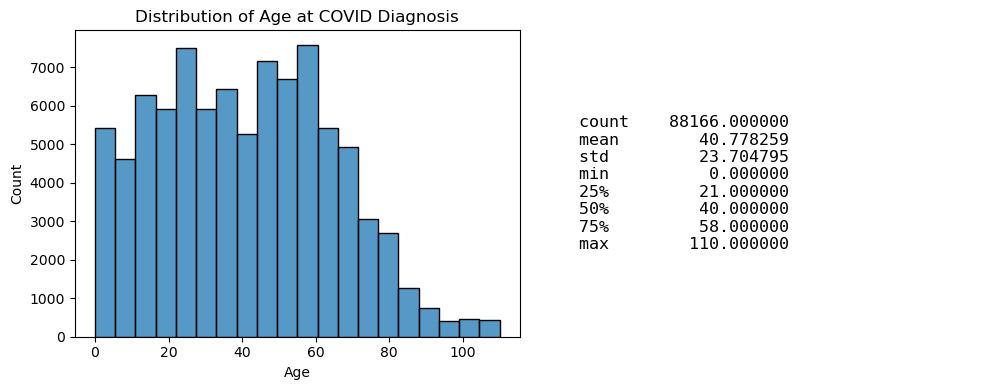

In [337]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(merged_df['age_at_covid'], bins=20, ax=ax1)
ax1.set_title('Distribution of Age at COVID Diagnosis')
ax1.set_xlabel('Age')

# Generate the describe output
describe_text = merged_df['age_at_covid'].describe().to_string()

ax2.axis('off')
ax2.text(0.1, 0.5, describe_text, fontsize=12, verticalalignment='center', family='monospace')

plt.tight_layout()
plt.show()


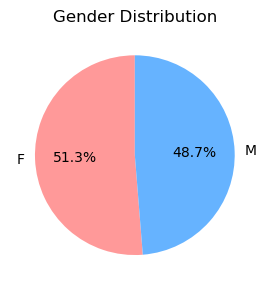

Females: 45205    Males: 42961


In [338]:
# Calculate gender distribution
gender_counts = merged_df['gender_source_value'].value_counts()

# Create a figure with just the pie chart
fig, ax1 = plt.subplots(figsize=(3, 3))

# Pie chart for gender distribution
ax1.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
ax1.set_title('Gender Distribution')

# Display the plot
plt.tight_layout()
plt.show()

print(f'Females: {gender_counts.F}    Males: {gender_counts.M}')

The patient population is predominantly white non-Hispanic, with notable representation from Black, Asian, and Hispanic individuals. This provides a clear overview of the demographic composition of the dataset.

In [339]:
# Race and Ethnicity breakdown
print(merged_df['race_source_value'].value_counts())
merged_df['ethnicity_source_value'].value_counts()

race_source_value
white     74065
black      7425
asian      6165
native      412
other        99
Name: count, dtype: int64


ethnicity_source_value
nonhispanic    78300
hispanic        9866
Name: count, dtype: int64

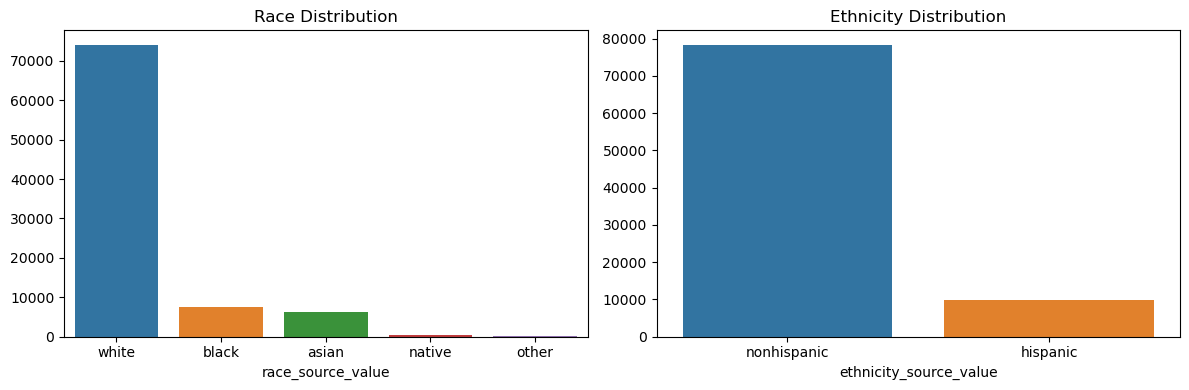

In [340]:
race_counts = merged_df['race_source_value'].value_counts()
ethnicity_counts = merged_df['ethnicity_source_value'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x=race_counts.index, y=race_counts.values, ax=ax[0])
ax[0].set_title('Race Distribution')

sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values, ax=ax[1])
ax[1].set_title('Ethnicity Distribution')

plt.tight_layout()
plt.show()


## Load in comorbidity data
The comorbidities data contains records of ongoing illnesses or conditions that were present at the time of COVID-19 diagnosis. We can see below that most of these lack end date as many of them are chronic coniditions.

In [341]:
comorbidities_df = pd.read_csv('covid_comorbidities.csv')
print(comorbidities_df.info())
comorbidities_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232396 entries, 0 to 232395
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   person_id             232396 non-null  int64 
 1   condition_concept_id  232396 non-null  int64 
 2   concept_name          232396 non-null  object
 3   condition_start_date  232396 non-null  object
 4   condition_end_date    16770 non-null   object
dtypes: int64(2), object(3)
memory usage: 8.9+ MB
None


,person_id,condition_concept_id,concept_name,condition_start_date,condition_end_date
0,1,381316,Cerebrovascular accident,1980-10-28,NaN
1,1,4311629,Impaired glucose tolerance,2002-12-17,NaN


### Merge the comorbid conditions with our previous dataframe

In [342]:
# Merge comorbidities with COVID occurrence dates (merged_df)
comorbidities_merged = pd.merge(
    comorbidities_df, 
    merged_df[['person_id', 'condition_start_date', 'condition_end_date', 'age_at_covid']], 
    on='person_id', 
    how='left',
    suffixes=('', '_covid')
)

# Rename covid start/end dates for clarity
comorbidities_merged.rename(columns={'condition_start_date_covid':'covid_start_date', 'condition_end_date_covid':'covid_end_date'}, inplace=True)

# Dates to datetime
comorbidities_merged['condition_start_date'] = pd.to_datetime(comorbidities_merged['condition_start_date'], errors='coerce')
comorbidities_merged['condition_end_date'] = pd.to_datetime(comorbidities_merged['condition_end_date'], errors='coerce')
comorbidities_merged['covid_start_date'] = pd.to_datetime(comorbidities_merged['covid_start_date'], errors='coerce')
comorbidities_merged['covid_end_date'] = pd.to_datetime(comorbidities_merged['covid_end_date'], errors='coerce')


# Quick check
print(comorbidities_merged.info())
comorbidities_merged.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232396 entries, 0 to 232395
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   person_id             232396 non-null  int64         
 1   condition_concept_id  232396 non-null  int64         
 2   concept_name          232396 non-null  object        
 3   condition_start_date  232396 non-null  datetime64[ns]
 4   condition_end_date    16770 non-null   datetime64[ns]
 5   covid_start_date      232396 non-null  datetime64[ns]
 6   covid_end_date        213768 non-null  datetime64[ns]
 7   age_at_covid          232396 non-null  int64         
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 14.2+ MB
None


,person_id,condition_concept_id,concept_name,condition_start_date,condition_end_date,covid_start_date,covid_end_date,age_at_covid
0,1,381316,Cerebrovascular accident,1980-10-28,NaT,2020-03-11,2020-03-24,61
1,1,4311629,Impaired glucose tolerance,2002-12-17,NaT,2020-03-11,2020-03-24,61


#### Analyze common conditions
We can take a quick look at some of the most common conditions these patients have. Since we know COVID-19 to infect almost everyone we would expect to see some of the most common conditions here.

In [343]:
# Analyze the most common comorbidities
common_comorbidities = comorbidities_merged['concept_name'].value_counts().head(10)

# Display the most common comorbidities
common_comorbidities

concept_name
Impaired glucose tolerance        25316
Essential hypertension            22946
Anemia                            22420
Chronic sinusitis                 17499
Miscarriage in first trimester    14904
Hyperlipidemia                     9127
Type 2 diabetes mellitus           5453
Hypertriglyceridemia               5325
Metabolic syndrome X               5233
Osteoarthritis of knee             4209
Name: count, dtype: int64

#### Adding age groups field
To assist in the analysis of these comorbidities, we will add a field that groups patients by ages. The age ranges selected were chosen to match those used by the CDC report here: https://www.cdc.gov/nchs/nvss/vsrr/covid_weekly/index.htm#SexAndAge

In [344]:
# Define age bins and labels
age_bins = [0, 18, 30, 40, 50, 65, 75, 85, 1000]  
age_labels = ['0-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75-84', '85+']

# Create age group column using the age groups
comorbidities_merged['age_group'] = pd.cut(comorbidities_merged['age_at_covid'], bins=age_bins, labels=age_labels)

# Verify the new column
# comorbidities_merged[['age_at_covid', 'age_group']][0:1000]
comorbidities_merged.head()


,person_id,condition_concept_id,concept_name,condition_start_date,condition_end_date,covid_start_date,covid_end_date,age_at_covid,age_group
0,1,381316,Cerebrovascular accident,1980-10-28,NaT,2020-03-11,2020-03-24,61,50-64
1,1,4311629,Impaired glucose tolerance,2002-12-17,NaT,2020-03-11,2020-03-24,61,50-64
2,1,439777,Anemia,2003-07-15,NaT,2020-03-11,2020-03-24,61,50-64
3,1,432867,Hyperlipidemia,2008-12-02,NaT,2020-03-11,2020-03-24,61,50-64
4,2,4311629,Impaired glucose tolerance,1985-10-08,NaT,2020-03-02,2020-03-17,74,65-74


#### Removing rows for certain redundant or flawed conditions
Several diabetes related conditions appear quite frequently in the data and do not add much insight to the analysis of comorbid conditions in this context. Removing them will help avoid over-representing type 2 diabetes and ensures clarity. In addition, occurrences of the condition, 'Miscarriage in first trimester', are not assigned end dates in our data for some reason. As a result, a miscarriage from 30 years prior still shows as an ongoing condition. Because it is unlikely these are relevant to our study, we will remove these rows as well.

In [345]:
# Record number of starting rows
nrow_start = comorbidities_merged.shape[0]

# List of conditions to remove
conditions_to_remove = [
    'Retinopathy due to type 2 diabetes mellitus',
    'Nonproliferative retinopathy due to type 2 diabetes mellitus',
    'Neuropathy due to type 2 diabetes mellitus',
    'Proliferative retinopathy due to type 2 diabetes mellitus',
    'Miscarriage in first trimester',
    'Microalbuminuria due to type 2 diabetes mellitus',
    'Disorder of kidney due to diabetes mellitus',
    'Macular edema and retinopathy due to type 2 diabetes mellitus',
    'Proteinuria due to type 2 diabetes mellitus',
    'Non-small cell carcinoma of lung, TNM stage 1',
    'Neoplasm of prostate'
    
]

# Remove rows where 'concept_name' matches any of the listed conditions
comorbidities_merged = comorbidities_merged[~comorbidities_merged['concept_name'].isin(conditions_to_remove)]

nrow_end = comorbidities_merged.shape[0]
# Check the filtered data
print(f'Total rows rows removed: {nrow_start - nrow_end}\nRows remaining: {nrow_end}')
comorbidities_merged.head(2)

Total rows rows removed: 23214
Rows remaining: 209182


,person_id,condition_concept_id,concept_name,condition_start_date,condition_end_date,covid_start_date,covid_end_date,age_at_covid,age_group
0,1,381316,Cerebrovascular accident,1980-10-28,NaT,2020-03-11,2020-03-24,61,50-64
1,1,4311629,Impaired glucose tolerance,2002-12-17,NaT,2020-03-11,2020-03-24,61,50-64


#### Grouping by age 
We can take a brief look a the most common conditions and their counts across age ranges.

In [346]:
# Group by age group and comorbidity, and count occurrences
comorbidities_by_age = comorbidities_merged.groupby(['age_group', 'concept_name'], observed=True).size().unstack(fill_value=0)

# Sum the occurrences of each comorbidity across all age groups
comorbidity_sums = comorbidities_by_age.sum(axis=0)

# Sort the columns of the DataFrame by the summed counts
comorbidities_by_age = comorbidities_by_age[comorbidity_sums.sort_values(ascending=False).index]

# Display to verify (10 most frequent conditions)
comorbidities_by_age.iloc[:, :10]


concept_name,Impaired glucose tolerance,Essential hypertension,Anemia,Chronic sinusitis,Hyperlipidemia,Type 2 diabetes mellitus,Hypertriglyceridemia,Metabolic syndrome X,Osteoarthritis of knee,Chronic intractable migraine without aura
age_group,,,,,,,,,,
0-17,11,321,20,946,0,3,2,0,0,238
18-29,1295,4490,1121,2002,0,222,160,135,0,767
30-39,2634,3472,2343,1895,11,557,507,474,114,618
40-49,4538,3924,3971,2621,796,1059,1020,1012,560,677
50-64,9509,6120,8400,5211,3393,2014,2020,2008,1852,1028
65-74,3868,2470,3438,2371,2336,792,798,794,884,422
75-84,2144,1307,1959,1423,1622,439,445,441,505,259
85+,1317,842,1168,1028,969,367,373,369,294,155


As well as by percentage of age group.

In [347]:
# Get the total counts for each age group
total_counts_by_age = comorbidities_merged['age_group'].value_counts(sort=False)

# Display percentage of respective population (ten most frequent conditions)
(comorbidities_by_age.div(total_counts_by_age, axis=0) * 100).round(2).iloc[:, :10]

concept_name,Impaired glucose tolerance,Essential hypertension,Anemia,Chronic sinusitis,Hyperlipidemia,Type 2 diabetes mellitus,Hypertriglyceridemia,Metabolic syndrome X,Osteoarthritis of knee,Chronic intractable migraine without aura
age_group,,,,,,,,,,
0-17,0.10,2.80,0.17,8.27,0.00,0.03,0.02,0.00,0.00,2.08
18-29,6.72,23.28,5.81,10.38,0.00,1.15,0.83,0.70,0.00,3.98
30-39,12.92,17.03,11.49,9.30,0.05,2.73,2.49,2.33,0.56,3.03
40-49,14.92,12.90,13.06,8.62,2.62,3.48,3.35,3.33,1.84,2.23
50-64,15.15,9.75,13.38,8.30,5.40,3.21,3.22,3.20,2.95,1.64
65-74,12.75,8.14,11.33,7.82,7.70,2.61,2.63,2.62,2.91,1.39
75-84,10.83,6.60,9.89,7.19,8.19,2.22,2.25,2.23,2.55,1.31
85+,9.08,5.81,8.05,7.09,6.68,2.53,2.57,2.54,2.03,1.07


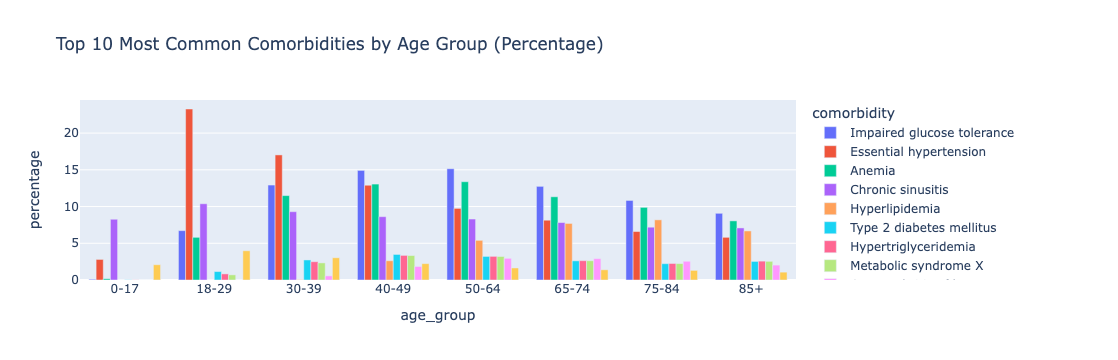

In [348]:
# Calculate the percentage of comorbidities per age group
comorbidities_percentage_by_age = (comorbidities_by_age.div(total_counts_by_age, axis=0) * 100).round(2).iloc[:, :10]

# Convert DataFrame to a long format for Plotly
comorbidities_melted = comorbidities_percentage_by_age.reset_index().melt(id_vars='age_group', var_name='comorbidity', value_name='percentage')

# Create an interactive bar plot for percentages
fig = px.bar(comorbidities_melted, x='age_group', y='percentage', color='comorbidity', barmode='group',
             title='Top 10 Most Common Comorbidities by Age Group (Percentage)')

fig.show()

## Bring in death data
The deaths table contains all recorded deaths amongst patients who have been diagnosed with COVID-19. These deaths need not be caused by COVID-19. We can see the data is complete. However, a quick inspection finds that many values are duplicated. All of the values are represented at least twice. This was a problem with the orignal data and was incorporated in my SQL queries. But when I checked back the next day it was no longer a problem. Maybe someone removed duplicates from the original data and the original data was reestablished after and update. Anyway, this will be handled below.

In [349]:
deaths_df = pd.read_csv('covid_deaths.csv')

# Merge deaths_df with persons_df to add the age_at_covid column
# This will be needed later on
deaths_df = pd.merge(
    deaths_df,
    persons_df[['person_id', 'age_at_covid']],  # Inherit age_at_covid from persons_df
    on='person_id', 
    how='left'
)

print(deaths_df.info())
deaths_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   person_id         7200 non-null   int64 
 1   death_datetime    7200 non-null   object
 2   cause_concept_id  7200 non-null   int64 
 3   cause_of_death    7200 non-null   object
 4   age_at_covid      7200 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 281.4+ KB
None


,person_id,death_datetime,cause_concept_id,cause_of_death,age_at_covid
0,125,2020-04-03 00:00:00,37311061,COVID-19,72
1,125,2020-04-03 00:00:00,37311061,COVID-19,72


#### Drop the duplicate rows

In [350]:
# Drop all exact duplicate rows from deaths_df
deaths_df = deaths_df.drop_duplicates()

#### Filter for only COVID-19 deaths

In [351]:
deaths_df.cause_of_death.value_counts()

cause_of_death
COVID-19                                       3518
Pneumonia                                        13
Cerebrovascular accident                         12
Myocardial infarction                            11
Alzheimer's disease                               9
Pulmonary emphysema                               5
Drug overdose                                     4
Malignant tumor of colon                          4
Non-small cell lung cancer                        4
Cardiac arrest                                    3
Secondary malignant neoplasm of colon             3
Sudden cardiac death                              3
Familial Alzheimer's disease of early onset       3
Neoplasm of prostate                              2
Overlapping malignant neoplasm of colon           2
Bullet wound                                      2
Emphysematous bronchitis                          1
Concussion injury of brain                        1
Name: count, dtype: int64

In [352]:
# Filter for deaths caused by COVID-19
deaths_df = deaths_df[deaths_df['cause_of_death'] == 'COVID-19']

# Check the result
print(deaths_df.shape)
deaths_df.head(2)

(3518, 5)


,person_id,death_datetime,cause_concept_id,cause_of_death,age_at_covid
0,125,2020-04-03 00:00:00,37311061,COVID-19,72
2,158,2020-03-29 00:00:00,37311061,COVID-19,50


#### Filter for 30 years or older
The vast majority of the deaths recorded have listed cause of death as COVID-19. This is helpful as we do not have to sort through different similar causes and deduce what may be COVID deaths. We will remove the other deaths. While in some circumstances we may want to be more careful here, because there are so few deaths other than COVID-19 we are okay to remove them.

In [353]:
deaths_df = deaths_df[deaths_df['age_at_covid'] > 30]

#### Merge death data with comorbidity data

In [354]:
# Perform a left join to keep only comorbidities of those who died
merged_with_deaths = pd.merge(
    deaths_df[['person_id', 'death_datetime', 'cause_of_death']],  # Keep only relevant death columns
    comorbidities_merged[['person_id', 'condition_concept_id', 'concept_name', 'age_group']],  # Focus on comorbidity and age data
    on='person_id', 
    how='left'  # Left join: retain all deaths, link comorbidities where possible
)

# Check the result of the merge
print(merged_with_deaths.shape)
merged_with_deaths.head(2)


(16312, 6)


,person_id,death_datetime,cause_of_death,condition_concept_id,concept_name,age_group
0,125,2020-04-03 00:00:00,COVID-19,201826.0,Type 2 diabetes mellitus,65-74
1,125,2020-04-03 00:00:00,COVID-19,4120314.0,Hypertriglyceridemia,65-74


#### Ensure no duplicates

In [355]:
merged_with_deaths = merged_with_deaths.drop_duplicates(subset=['person_id', 'concept_name'])
merged_with_deaths.shape

(16312, 6)

#### Add age groups to those death records that do not include them
Remaining records in death that are not part of the merge will still need age groups so we can properly count them.

In [356]:
death_bins = [30, 40, 50, 65, 75, 85, 1000]  
death_labels = ['30-39', '40-49', '50-64', '65-74', '75-84', '85+']

# Create age_group using the existing age_at_covid
deaths_df['age_group'] = pd.cut(deaths_df['age_at_covid'], bins=death_bins, labels=death_labels)


#### Visualize the number of deaths in each age group

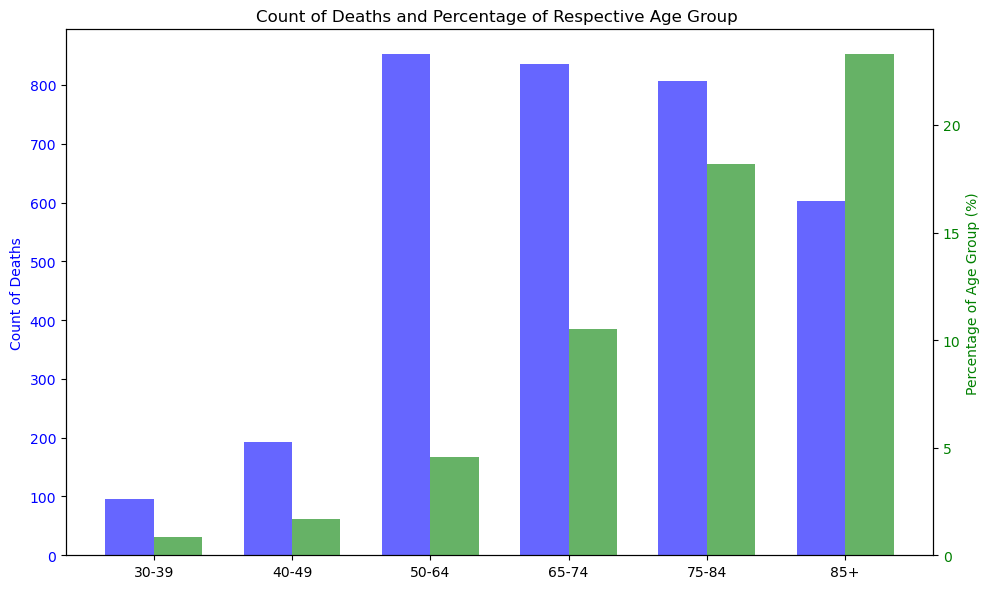

In [357]:
# Get the total number of deaths by age group
total_deaths_by_age = deaths_df.groupby('age_group', observed=False)['person_id'].nunique()

# Retrieve  x and y
age_groups = total_deaths_by_age.index
death_counts = total_deaths_by_age.values

# Create the age_group column in persons_df based on age_at_covid
persons_df['age_group'] = pd.cut(persons_df['age_at_covid'], bins=age_bins, labels=age_labels, right=False)

# Group by age_group and count the number of unique person_ids in each age group
population_by_age_group = persons_df.groupby('age_group', observed=False)['person_id'].nunique()

# Calculate percentage of deaths in each age group
death_percentages = [(death_counts[i] / population_by_age_group[age_group]) * 100 for i, age_group in enumerate(age_groups)]

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Step 1: Plot the count of deaths by age group on ax1
ax1.bar(np.arange(len(age_groups)), death_counts, bar_width, color='b', alpha=0.6, label='Count of Deaths')

# Label for the first y-axis (count of deaths)
ax1.set_ylabel('Count of Deaths', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Step 2: Plot the percentage of deaths on the second y-axis (ax2)
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax2.bar(np.arange(len(age_groups)) + bar_width, death_percentages, bar_width, color='g', alpha=0.6, label='Percentage of Age Group')

# Label for the second y-axis (percentage)
ax2.set_ylabel('Percentage of Age Group (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Titles and labels
ax1.set_xticks(np.arange(len(age_groups)) + bar_width / 2)
ax1.set_xticklabels(age_groups)
plt.title('Count of Deaths and Percentage of Respective Age Group ')

# Show the plot
plt.tight_layout()
plt.show()


#### Notably in the plot above
The death percentages seem pretty high, but this corresponds to the real-world values seen when COVID-19 pandemic first began. Additionally, it's important to remember that the data here contains only the first recorded diagnosis for each unique person

#### Inspect the above quantities along with conditions

Here we can inspect the number of people in each age category who had each condition and also died of COVID-19.  We have removed those conditions that fewer than 100 people had. This helps focus on the more common conditions. 100 here corresponds to about 3% of the deceased people.

In [358]:
# Group by age group and comorbidity, then count the number of deaths in each category
deaths_by_age_comorbidities = merged_with_deaths.groupby(
    ['age_group', 'concept_name'], observed=True).size().unstack(fill_value=0)

# Sort the columns based on the total counts in descending order
comorbidity_sums = deaths_by_age_comorbidities.sum(axis=0)
deaths_by_age_comorbidities = deaths_by_age_comorbidities[comorbidity_sums.sort_values(ascending=False).index]

# Set a threshold for minimum number of deaths for each comorbidity
threshold = 100 # ~ 3% of deaths 

# Filter the comorbidities with total deaths greater than the threshold
deaths_by_age_comorbidities = deaths_by_age_comorbidities.loc[:, comorbidity_sums > threshold]


# Display the final count table
deaths_by_age_comorbidities


concept_name,Impaired glucose tolerance,Anemia,Essential hypertension,Chronic sinusitis,Hyperlipidemia,Osteoporosis,Hypertriglyceridemia,Type 2 diabetes mellitus,Metabolic syndrome X,Cerebrovascular accident,Atrial fibrillation,Coronary arteriosclerosis,Osteoarthritis of knee,Polyp of colon,Hyperglycemia,Chronic kidney disease stage 1,Alzheimer's disease,Appendicitis,Drug overdose,Carcinoma in situ of prostate,Cardiac arrest,Malignant tumor of breast,Recurrent rectal polyp,Impacted molars,Chronic pain,Chronic intractable migraine without aura,"Localized, primary osteoarthritis of the hand",Fever,Osteoarthritis of hip,Tubal pregnancy,Seizure disorder,Cough,Pulmonary emphysema
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30-39,15,15,48,15,0,0,7,7,7,0,0,4,2,0,1,0,0,4,5,0,5,0,0,5,5,6,0,5,1,0,3,6,0
40-49,84,72,98,38,11,0,20,21,20,3,0,11,14,3,13,2,0,14,14,0,8,0,0,15,17,15,1,7,0,2,9,6,3
50-64,467,458,428,223,154,25,145,146,144,54,34,55,84,42,78,70,0,56,45,3,39,34,18,51,43,46,34,33,35,23,20,25,30
65-74,442,419,388,265,258,114,111,111,111,70,74,90,89,107,59,56,46,71,44,26,42,50,53,41,41,37,42,41,28,29,31,28,30
75-84,419,415,357,274,301,222,125,124,124,131,147,140,99,98,76,75,148,47,51,58,59,53,65,45,41,43,29,27,29,31,26,20,21
85+,322,307,263,244,245,255,114,112,112,226,203,146,65,82,62,80,73,52,43,114,43,52,52,28,31,29,33,20,32,39,22,17,17


#### And look at percentages as well
Some of these percentages looked unreasonably high to me at first (>50%). They have been investigated heavily and some discrepancies were identified and resolved. However after some internet searching it seems that these are perhaps reasonable rates, at least for the elderly. This is also synthetic data, though designed to be realistic.

In [359]:
# Calculate the percentage of individuals who died in each comorbidity category
percentage_by_age_comorbidities = deaths_by_age_comorbidities.div(total_deaths_by_age, axis=0) * 100

# Display the final percentage table
percentage_by_age_comorbidities


concept_name,Impaired glucose tolerance,Anemia,Essential hypertension,Chronic sinusitis,Hyperlipidemia,Osteoporosis,Hypertriglyceridemia,Type 2 diabetes mellitus,Metabolic syndrome X,Cerebrovascular accident,Atrial fibrillation,Coronary arteriosclerosis,Osteoarthritis of knee,Polyp of colon,Hyperglycemia,Chronic kidney disease stage 1,Alzheimer's disease,Appendicitis,Drug overdose,Carcinoma in situ of prostate,Cardiac arrest,Malignant tumor of breast,Recurrent rectal polyp,Impacted molars,Chronic pain,Chronic intractable migraine without aura,"Localized, primary osteoarthritis of the hand",Fever,Osteoarthritis of hip,Tubal pregnancy,Seizure disorder,Cough,Pulmonary emphysema
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30-39,15.789474,15.789474,50.526316,15.789474,0.000000,0.000000,7.368421,7.368421,7.368421,0.000000,0.000000,4.210526,2.105263,0.000000,1.052632,0.000000,0.000000,4.210526,5.263158,0.000000,5.263158,0.000000,0.000000,5.263158,5.263158,6.315789,0.000000,5.263158,1.052632,0.000000,3.157895,6.315789,0.000000
40-49,43.750000,37.500000,51.041667,19.791667,5.729167,0.000000,10.416667,10.937500,10.416667,1.562500,0.000000,5.729167,7.291667,1.562500,6.770833,1.041667,0.000000,7.291667,7.291667,0.000000,4.166667,0.000000,0.000000,7.812500,8.854167,7.812500,0.520833,3.645833,0.000000,1.041667,4.687500,3.125000,1.562500
50-64,54.812207,53.755869,50.234742,26.173709,18.075117,2.934272,17.018779,17.136150,16.901408,6.338028,3.990610,6.455399,9.859155,4.929577,9.154930,8.215962,0.000000,6.572770,5.281690,0.352113,4.577465,3.990610,2.112676,5.985915,5.046948,5.399061,3.990610,3.873239,4.107981,2.699531,2.347418,2.934272,3.521127
65-74,52.934132,50.179641,46.467066,31.736527,30.898204,13.652695,13.293413,13.293413,13.293413,8.383234,8.862275,10.778443,10.658683,12.814371,7.065868,6.706587,5.508982,8.502994,5.269461,3.113772,5.029940,5.988024,6.347305,4.910180,4.910180,4.431138,5.029940,4.910180,3.353293,3.473054,3.712575,3.353293,3.592814
75-84,51.920694,51.425031,44.237918,33.952912,37.298637,27.509294,15.489467,15.365551,15.365551,16.232962,18.215613,17.348203,12.267658,12.143742,9.417596,9.293680,18.339529,5.824040,6.319703,7.187113,7.311029,6.567534,8.054523,5.576208,5.080545,5.328377,3.593556,3.345725,3.593556,3.841388,3.221809,2.478315,2.602230
85+,53.399668,50.912106,43.615257,40.464345,40.630182,42.288557,18.905473,18.573798,18.573798,37.479270,33.665008,24.212272,10.779436,13.598673,10.281924,13.266998,12.106136,8.623549,7.131012,18.905473,7.131012,8.623549,8.623549,4.643449,5.140962,4.809287,5.472637,3.316750,5.306799,6.467662,3.648425,2.819237,2.819237


##### Verify percentage calculation

In [360]:
# Graph percentage
print(f'Percentage of death in COVID-19 patients of age 85+ {round(death_percentages[-1], 2)}%')

Percentage of death in COVID-19 patients of age 85+ 23.28%


Let's recalculate the raw numbers to check.

In [361]:
# Get the total population for age group 85+ from persons_df
total_population_85_plus = persons_df[persons_df['age_group'] == '85+']['person_id'].nunique()

# Display the result
print(f"Total population for age group 85+: {total_population_85_plus}")

Total population for age group 85+: 2590


In [362]:
total_deaths_85_plus = deaths_df[deaths_df['age_group'] == '85+']['person_id'].nunique()

# Display the result
print(f"Total deaths for age group 85+: {total_deaths_85_plus}")

Total deaths for age group 85+: 603


In [363]:
print(f'Recalculated death % for 85 or older: {round((603/2590) * 100, 2)}%')

Recalculated death % for 85 or older: 23.28%


#### Lets look at these most common comorbidities with plots

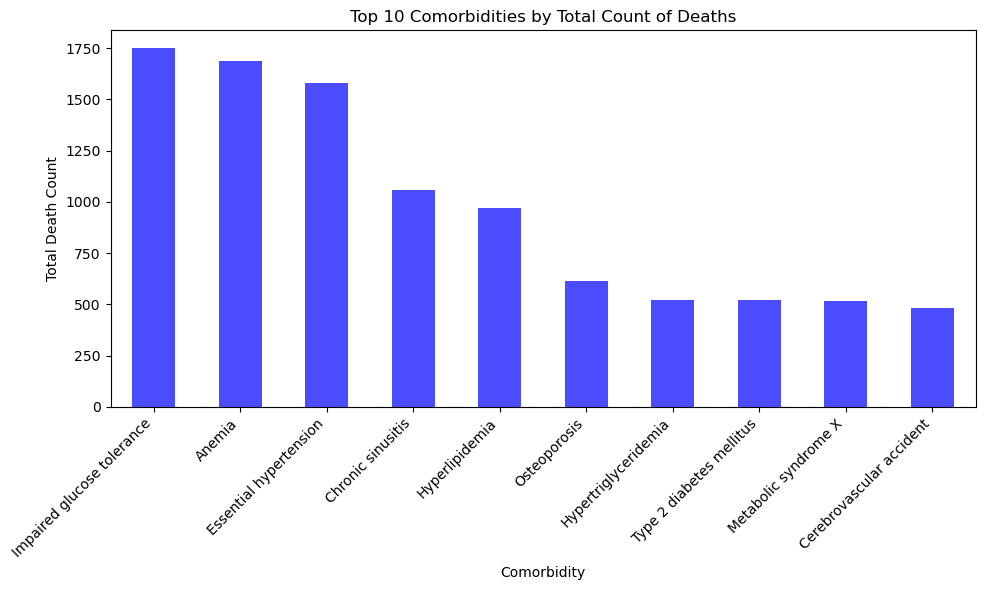

In [364]:
# Get the top 10 comorbidities by total count of deaths
top_comorbidities = comorbidity_sums.sort_values(ascending=False).head(10)

# Plot the top comorbidities
plt.figure(figsize=(10, 6))
top_comorbidities.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Top 10 Comorbidities by Total Count of Deaths')
plt.ylabel('Total Death Count')
plt.xlabel('Comorbidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


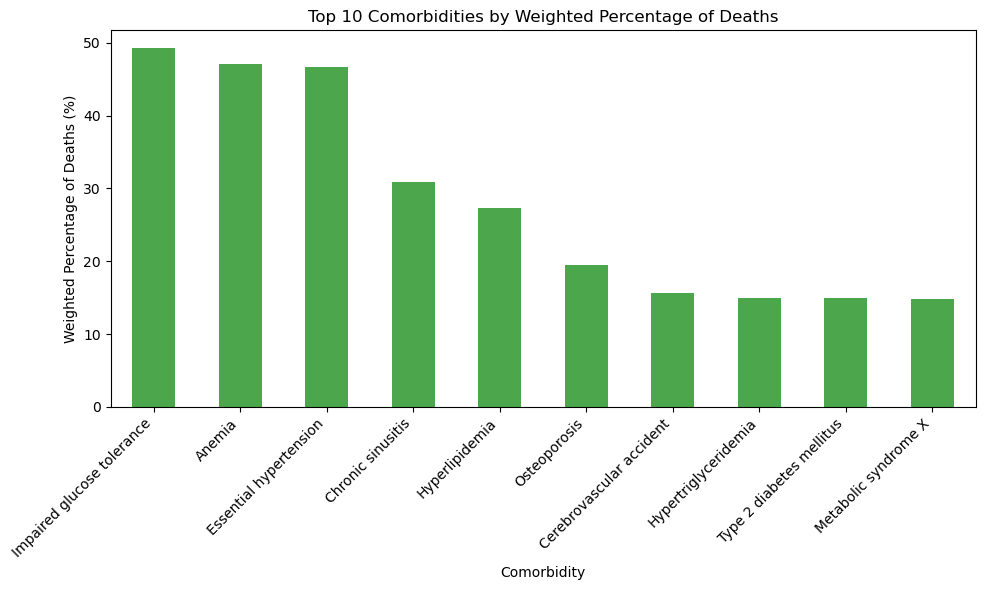

In [365]:
# Calculate the total number of deaths across all age groups
total_deaths_by_age = percentage_by_age_comorbidities.sum(axis=1)

# Calculate the weighted mean for each comorbidity across all age groups
weighted_comorbidities = (percentage_by_age_comorbidities.T * total_deaths_by_age).sum(axis=1) / total_deaths_by_age.sum()

# Sort the comorbidities by their weighted percentages
top_weighted_comorbidities = weighted_comorbidities.sort_values(ascending=False).head(10)

# Plot the top comorbidities by weighted percentage
plt.figure(figsize=(10, 6))
top_weighted_comorbidities.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 10 Comorbidities by Weighted Percentage of Deaths')
plt.ylabel('Weighted Percentage of Deaths (%)')
plt.xlabel('Comorbidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


There are definitely quite a few conditions that stand out. However, we don't really know how these compare to the general population. 

#### Let's first take the percentage of conditions in our whole set of people diagnosed with COVID-19
For each comorbidity find the percentage of people (30+) who had this condition ongoing at COVID diagnosis.

In [366]:
persons_df.head(2)

,person_id,gender_source_value,birth_datetime,age_at_covid,race_source_value,ethnicity_source_value,covid_start_date,age_group
0,1,F,1958-12-02,61,white,nonhispanic,2020-03-11,50-64
1,2,F,1945-10-02,74,white,nonhispanic,2020-03-02,65-74


In [367]:
total_people_30p = len(persons_df.loc[persons_df.age_at_covid > 29].person_id.unique())
total_people_30p

56012

In [368]:
comorbidities_merged_30p = comorbidities_merged.loc[comorbidities_merged.age_at_covid > 29]
comorbidities_merged_30p.shape

(180040, 9)

In [369]:
# Step 1: Group by 'concept_name' and count unique 'person_id's
comorbidity_totals_population = comorbidities_merged_30p.groupby('concept_name')['person_id'].nunique()

# Step 3: Calculate the percentage of unique people with each comorbidity
comorbidity_percent_population = (comorbidity_totals_population / total_people_30p) * 100

# Step 4: Sort by prevalence in descending order (optional, for viewing)
comorbidity_percent_population = comorbidity_percent_population.sort_values(ascending=False)

# Display the result
comorbidity_percent_population.head(10)

concept_name
Impaired glucose tolerance    43.194316
Anemia                        38.293580
Essential hypertension        33.007213
Chronic sinusitis             26.358637
Hyperlipidemia                16.294723
Type 2 diabetes mellitus       9.397986
Hypertriglyceridemia           9.273013
Metabolic syndrome X           9.151610
Osteoarthritis of knee         7.514461
Osteoporosis                   6.241520
Name: person_id, dtype: float64

#### Now, take the percentage of conditions in our set of people who died from COVID-19
Since deaths have already been filtered for people 30+ we can do:

In [370]:
# Group by 'concept_name' and count unique 'person_id's in the death group
comorbidity_totals_deaths = merged_with_deaths.groupby('concept_name')['person_id'].nunique()

# Calculate the percentage of unique people with each comorbidity in the death group
total_deaths = merged_with_deaths['person_id'].nunique()
comorbidity_totals_deaths = (comorbidity_totals_deaths / total_deaths) * 100

# Sort by prevalence in descending order
comorbidity_totals_deaths = comorbidity_totals_deaths.sort_values(ascending=False)

# Display the top comorbidities by prevalence in the death group
comorbidity_totals_deaths.head(10)


concept_name
Impaired glucose tolerance    51.684397
Anemia                        49.822695
Essential hypertension        46.749409
Chronic sinusitis             31.294326
Hyperlipidemia                28.634752
Osteoporosis                  18.203310
Hypertriglyceridemia          15.425532
Type 2 diabetes mellitus      15.395981
Metabolic syndrome X          15.307329
Cerebrovascular accident      14.302600
Name: person_id, dtype: float64

#### Lets compare population with COVID-19 to population who died from COVID-19
We will record the difference in percent of population for each group as well as the relative difference (difference/percent in overall population)

In [371]:
# Ensure the indices are aligned and fill missing values with 0
comorbidity_percent_population_aligned = comorbidity_percent_population.reindex(comorbidity_totals_deaths.index, fill_value=0)

# Create the comparison DataFrame for death group vs. general population
comparison_df = pd.DataFrame({
    'Percentage in Deaths': comorbidity_totals_deaths,
    'Percentage in General Population': comorbidity_percent_population_aligned,
    'Difference (Deaths - Population)': comorbidity_totals_deaths - comorbidity_percent_population_aligned,
    'Relative Difference': ((comorbidity_totals_deaths - comorbidity_percent_population_aligned) / comorbidity_percent_population_aligned.replace(0, np.nan)) * 100  # Avoid division by zero
})

# Round all values in the DataFrame to 2 decimal places
comparison_df = comparison_df.round(2)

# Sort the DataFrame by 'Difference (Deaths - Population)'
comparison_df = comparison_df.sort_values(by='Relative Difference', ascending=False)

# Display the top comorbidities with the largest relative difference
comparison_df.head(10)


,Percentage in Deaths,Percentage in General Population,Difference (Deaths - Population),Relative Difference
concept_name,,,,
Closed fracture of hip,0.15,0.02,0.12,491.14
At risk for suicide,0.06,0.01,0.05,372.91
Pathological fracture due to osteoporosis,0.24,0.05,0.18,341.39
Carcinoma in situ of prostate,5.94,1.60,4.34,271.73
Facial laceration,0.06,0.02,0.04,267.82
Epidermal burn of skin,0.06,0.02,0.04,267.82
Alzheimer's disease,7.89,2.20,5.69,258.14
Non-small cell lung cancer,0.50,0.15,0.36,243.15
Chronic congestive heart failure,2.90,0.87,2.02,232.40


#### We can use chi2 to compare the differences in the two groups
Let's take for example the condition, 'Impaired glucose tolerance'

In [372]:
from scipy.stats import chi2_contingency

# For the death group
death_with_comorbidity = merged_with_deaths[merged_with_deaths['concept_name'] == 'Impaired glucose tolerance']['person_id'].nunique()
death_without_comorbidity = total_deaths - death_with_comorbidity

# For the general population (people 30+)
pop_with_comorbidity = comorbidities_merged_30p[comorbidities_merged_30p['concept_name'] == 'Impaired glucose tolerance']['person_id'].nunique()
pop_without_comorbidity = total_people_30p - pop_with_comorbidity

contingency_table = [
    [death_with_comorbidity, death_without_comorbidity],  # death group
    [pop_with_comorbidity, pop_without_comorbidity]       # general population
]


# Perform the chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")


Chi-Squared Statistic: 93.16068588241164
P-value: 4.821642197138839e-22


Based on the Chi-Squared statistic of 93 and the tiny p_value, we can conclude that the prevalence of 'Impaired glucose tolerance' is significantly higher in the population who died of COVID-19 compared to the population of people diagnosed with COVID-19.

#### Let's repeat the process for each of our comorbidities

In [373]:
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize a dictionary to store the results
chi2_results = {}

# List of comorbidities to test
comorbidities_list = merged_with_deaths['concept_name'].unique()

# Loop through each comorbidity
for comorbidity in comorbidities_list:
    # Get counts for the death group
    death_with_comorbidity = merged_with_deaths[merged_with_deaths['concept_name'] == comorbidity]['person_id'].nunique()
    death_without_comorbidity = total_deaths - death_with_comorbidity

    # Get counts for the general population (people 30+)
    pop_with_comorbidity = comorbidities_merged_30p[comorbidities_merged_30p['concept_name'] == comorbidity]['person_id'].nunique()
    pop_without_comorbidity = total_people_30p - pop_with_comorbidity

    # Create the contingency table
    contingency_table = [
        [death_with_comorbidity, death_without_comorbidity],
        [pop_with_comorbidity, pop_without_comorbidity]
    ]

    # Perform the chi-square test
    try:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi2_results[comorbidity] = {
            'Chi-Squared Statistic': chi2_stat,
            'P-value': p_value,
            'Death with Comorbidity': death_with_comorbidity,
            'Population with Comorbidity': pop_with_comorbidity
        }
    except ValueError:
        # In case of errors with the contingency table (e.g., if one of the counts is zero)
        chi2_results[comorbidity] = {
            'Chi-Squared Statistic': None,
            'P-value': None,
            'Death with Comorbidity': death_with_comorbidity,
            'Population with Comorbidity': pop_with_comorbidity
        }

# Convert the results to a DataFrame for easy inspection
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')

# Sort the DataFrame by the P-value
chi2_df = chi2_df.sort_values(by='P-value')

# Display the DataFrame
chi2_df.head(5)


,Chi-Squared Statistic,P-value,Death with Comorbidity,Population with Comorbidity
Osteoporosis,706.756735,1.014887e-155,616,3496
Atrial fibrillation,533.964855,3.875959e-118,458,2549
Coronary arteriosclerosis,454.984867,5.933127e-101,446,2663
Alzheimer's disease,416.689601,1.282332e-92,267,1234
Cerebrovascular accident,408.669497,7.140752e-91,484,3180


And add in some helpful columns.

In [374]:
# Add the percentage difference in a separate block
chi2_df['Percentage Difference'] = ((chi2_df['Death with Comorbidity'] / total_deaths) - 
                                    (chi2_df['Population with Comorbidity'] / total_people_30p)) * 100

# Add the relative difference (difference / percentage in general population) in a separate block
chi2_df['Relative Difference (%)'] = (((chi2_df['Death with Comorbidity'] / total_deaths) - 
                                       (chi2_df['Population with Comorbidity'] / total_people_30p)) /
                                       (chi2_df['Population with Comorbidity'] / total_people_30p)) * 100

# Display the updated DataFrame with the percentage difference
chi2_df.head()


,Chi-Squared Statistic,P-value,Death with Comorbidity,Population with Comorbidity,Percentage Difference,Relative Difference (%)
Osteoporosis,706.756735,1.014887e-155,616,3496,11.961790,191.648679
Atrial fibrillation,533.964855,3.875959e-118,458,2549,8.983468,197.403701
Coronary arteriosclerosis,454.984867,5.933127e-101,446,2663,8.425331,177.213527
Alzheimer's disease,416.689601,1.282332e-92,267,1234,5.686972,258.135051
Cerebrovascular accident,408.669497,7.140752e-91,484,3180,8.625246,151.923666


#### Let's look at those significant differences (p_value < .05 and Deaths with comorbidity > 10)  
P_value chosen to be .05 and a minimum recorded occurrences of condition must be > 10 in the deceased population.

In [376]:
# Filter rows where the P-value is less than 0.05
significant_df = chi2_df[chi2_df['P-value'] < 0.05]

# Filter rows where total deaths with the comorbidity is > 10
significant_df = significant_df[significant_df['Death with Comorbidity'] > 10]

# Sort by largest relative difference (descending)
significant_df = significant_df.sort_values(by='Relative Difference (%)', ascending=False)

# Display the sorted DataFrame
significant_df.head(10)


,Chi-Squared Statistic,P-value,Death with Comorbidity,Population with Comorbidity,Percentage Difference,Relative Difference (%)
Carcinoma in situ of prostate,329.759990,1.084081e-73,201,895,4.341844,271.726693
Alzheimer's disease,416.689601,1.282332e-92,267,1234,5.686972,258.135051
Non-small cell lung cancer,22.208617,2.445737e-06,17,82,0.355967,243.151416
Chronic congestive heart failure,131.859208,1.606158e-30,98,488,2.024739,232.396911
Recurrent rectal polyp,223.080874,1.924806e-50,188,1016,3.741659,206.277340
Atrial fibrillation,533.964855,3.875959e-118,458,2549,8.983468,197.403701
Osteoporosis,706.756735,1.014887e-155,616,3496,11.961790,191.648679
Myocardial infarction,26.691753,2.386379e-07,27,155,0.521146,188.325326
Coronary arteriosclerosis,454.984867,5.933127e-101,446,2663,8.425331,177.213527
Polyp of colon,283.348473,1.399333e-63,332,2148,5.975982,155.831804


##### The following is a plot of the greatest relative differences amongst significant comorbidities.

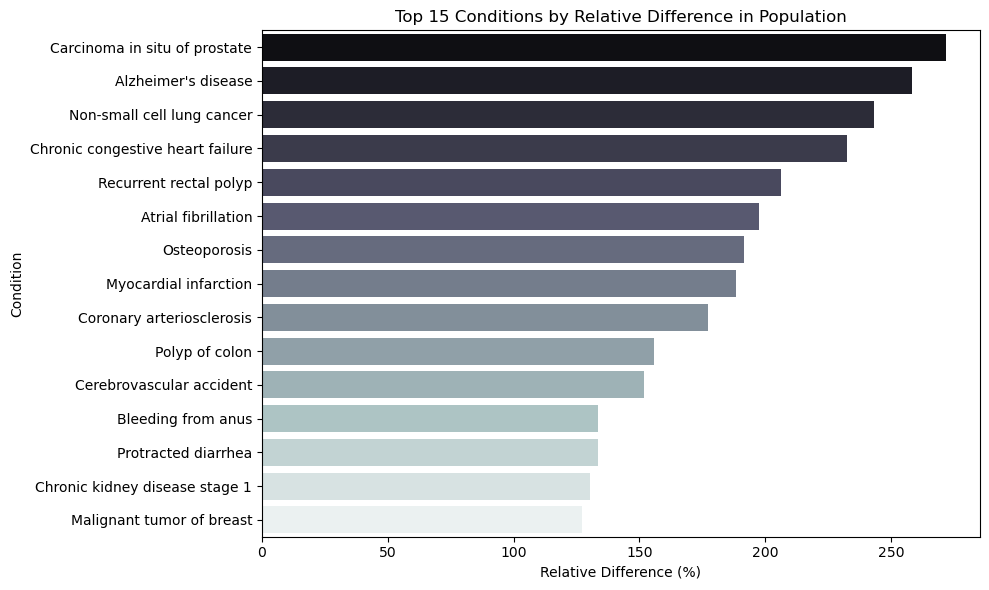

In [377]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the top 15 conditions from significant_df
top_15_conditions = significant_df.head(15)

# Create the bar plot for Relative Difference
plt.figure(figsize=(10, 6))
sns.barplot(x='Relative Difference (%)', y=top_15_conditions.index, data=top_15_conditions, palette='bone')

# Add labels and title
plt.xlabel('Relative Difference (%)')
plt.ylabel('Condition')
plt.title('Top 15 Conditions by Relative Difference in Population')

# Display the plot
plt.tight_layout()
plt.show()


#### The most common conditions above are typically related to patients who are already considerably unwell and nearing end of life.  
These numbers are valuable but more or less expected. A little time spent exploring the data found the following more unnexpected outcomes:

In [382]:
# Define the conditions you want to filter for
conditions_to_filter = [
    "Opioid abuse", 
    "Alcoholism", 
    "Impaired glucose tolerance", 
    "Perennial allergic rhinitis", 
    "Rupture of appendix", 
    "Appendicitis"
]

significant_df[significant_df.index.isin(conditions_to_filter)]


,Chi-Squared Statistic,P-value,Death with Comorbidity,Population with Comorbidity,Percentage Difference,Relative Difference (%)
Opioid abuse,23.351251,1.349557e-06,44,337,0.698580,116.109322
Alcoholism,25.473366,4.485324e-07,49,379,0.771350,113.996956
Rupture of appendix,4.600717,3.195858e-02,75,955,0.511320,29.989603
Appendicitis,8.921571,2.818220e-03,244,3326,1.272389,21.427850
Impaired glucose tolerance,93.160686,4.821642e-22,1749,24194,8.490082,19.655553
Perennial allergic rhinitis,5.772079,1.628276e-02,41,1000,-0.573748,-32.136761


From the results above, we see that conditions of `Opiod abuse` or `Alcoholism` were twice as prevalent in the population that died. Additionally, it may have been in error to includ cases of `Appendicitis` and `Rupture of appendix` in the analysis as these conditions do not have end dates and thus were all considered ongoing at the time of COVID diagnosis. However, history of appendicitis/rupture was about 20% more common in the deceased population and statistically significant. A final interesting note was that a history of allergic rhihnitis showed statistically less prevalence in the deceased group. More investigation could perhaps explain these differences.

In some published studies on real data it was found that mental health conditions such as anxiety and depression show significant increases in those who die of COVID. While some differences were found here there were not enough to enable proper chi2 testing or any conclusions.

## Conclusion

In this analysis of COVID-19 comorbidities:

1. We briefly assessed the makeup of the data and the distribution of people by age, ethnicicty, gender
2. We explored the relationship between various comorbidities and COVID-19 outcomes, focusing on conditions prevalent in both the general population and those who passed away from the disease.f
3. Using Chi-Square tests we determined statistically significant differences in the prevalence of several comorbidities between the death population and the general population.
4. The conditions with the largest relative differences in prevalence between these populations include cancers such as prostate or lung cancer, heat conditions such as atrial fibrillation or prior myocardial infarction as well as other chronic conditions such as end-stage kidney disease. These are all typically end-of-life related conditions and so these results are expected, though the numbers help define which such conditions are significant and how prevalent they are.

### Future Directions
- Further analyses could explore potential confounding factors, such as age, gender, and socioeconomic status.
- In addition procedures and medication data could be explored to help better understand outcomes in the COVID-19 context.
- Alternatively the interesting findings on Appendicitis and Rhinisitis could be explored to understand why they are more/less common in deceased population.
